In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from diffprivlib.models import LogisticRegression as DPLR

from data_prep import convert_to_cat, one_hot_encode
from dp_synthesis import get_synthesizer, get_quail_synthesizer, save_synthetic_data, plot_distributions
from classification_metrics import get_classification_summary, get_table_metrics, get_epsilon_plots
from dp_model_metrics import dp_model_classification_helper, get_dp_model_table_metrics

from kanon import convert_to_str, get_spans, partition_dataset, is_k_anonymous, build_anonymized_dataset, drop_grouped_rows

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Convert all columns to categorical

In [3]:
# Read in sample directly
adult_data = pd.read_csv('acs_income_data_sample.csv', index_col=False)
adult_data.head()

,Unnamed: 0,label,race,sex,hours_week,native_country,occupation,marital,education,workclass,age,relationship
0,806757,>50K,White alone,Female,40.0,27.0,CMS,Married,Bachelor's degree,Employee of a private for-profit company or bu...,41.0,Reference person
1,296415,<=50K,White alone,Female,25.0,8.0,EAT,Married,Regular high school diploma,Employee of a private for-profit company or bu...,19.0,Biological son or daughter
2,717607,<=50K,White alone,Female,20.0,216.0,OFF,Married,Bachelor's degree,Employee of a private for-profit company or bu...,41.0,Husband/wife
3,1574145,<=50K,White alone,Female,25.0,53.0,SAL,Divorced,Regular high school diploma,Employee of a private for-profit company or bu...,56.0,Reference person
4,765750,<=50K,Black or African American alone,Male,40.0,26.0,HLS,Never married,Regular high school diploma,Employee of a private for-profit company or bu...,25.0,Biological son or daughter


In [4]:
adult_data.columns

Index(['Unnamed: 0', 'label', 'race', 'sex', 'hours_week', 'native_country',
       'occupation', 'marital', 'education', 'workclass', 'age',
       'relationship'],
      dtype='object')

In [5]:
# Get the categorical data
cat_adult = convert_to_cat(adult_data, dataset="acs")
cat_adult

,label,race,sex,hours_week,occupation,marital,education,workclass,age,relationship
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,1,0,1,1
2,0,0,0,1,2,0,0,0,0,2
3,0,0,0,1,3,1,1,0,2,0
4,0,1,1,0,4,2,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
29995,1,0,1,0,19,1,5,0,4,4
29996,1,0,0,0,17,0,0,0,0,0
29997,1,0,0,1,7,0,5,2,4,2
29998,0,0,1,0,17,2,4,4,3,11


In [6]:
# Get the one-hot encoded data
encoded_adult = one_hot_encode(cat_adult, dataset="acs")
encoded_adult

,label,sex,age_1,age_2,age_3,age_4,workclass_1,workclass_2,workclass_3,workclass_4,...,race_6,race_7,race_8,hours_week_1,hours_week_2,hours_week_3,marital_1,marital_2,marital_3,marital_4
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
29996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29997,1,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
29998,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [7]:
# Split the categorical and one-hot encoded data into train and test
cat_train, cat_test = train_test_split(cat_adult, test_size=0.2, random_state=0)
encoded_train, encoded_test = train_test_split(encoded_adult, test_size=0.2, random_state=0)

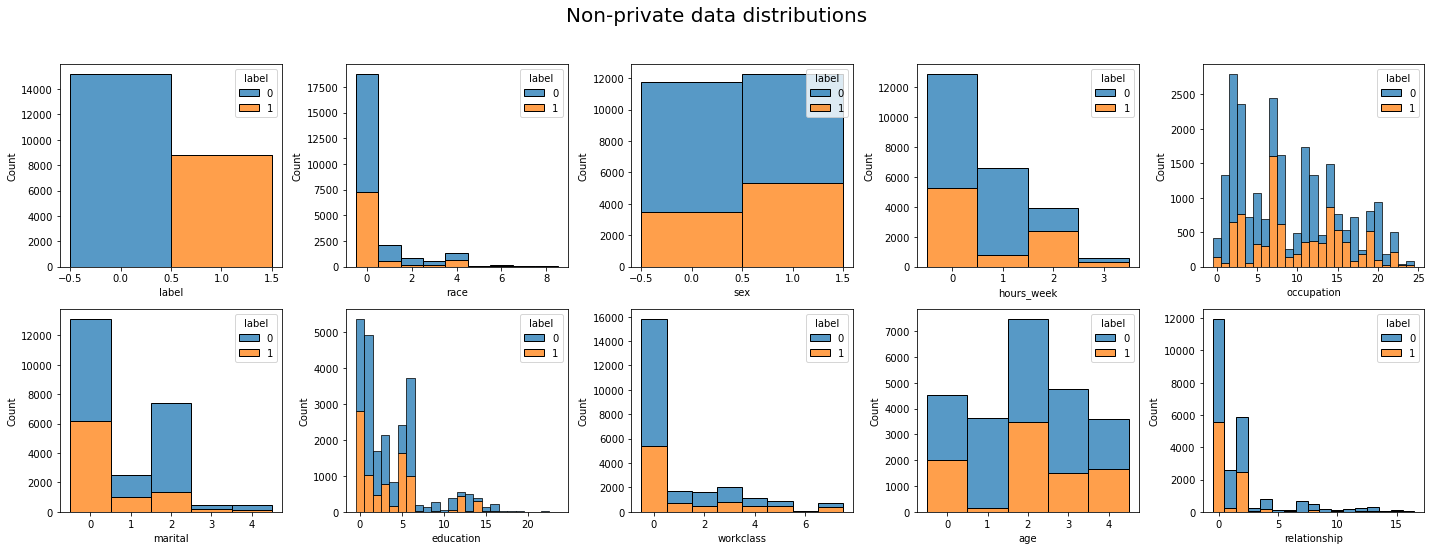

In [8]:
# Plot the non-private distributions
plot_distributions(cat_train, title="Non-private data distributions", dataset='acs')

# 2. Train binary classifier on non-private data

In [8]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="logistic", dataset="acs")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 0.5902, Male: 0.7252

False positive rates:
Female: 0.1033, Male: 0.1831

Equalized odds distances:
y=1: 0.1351, y=0: 0.0798

Classification accuracies:
Female: 0.8032, Male: 0.7776

F1-score: 0.7028

Avg train pred: 0.3396, Avg test pred: 0.3373


In [10]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="forest", dataset="acs")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.5879, Male: 0.6873

False positive rates:
Female: 0.1323, Male: 0.2156

Equalized odds distances:
y=1: 0.0994, y=0: 0.0832

Classification accuracies:
Female: 0.7823, Male: 0.7427

F1-score: 0.6679

Avg train pred: 0.3629, Avg test pred: 0.3478


# 3. New MWEM synthesis

In [9]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of synthetic data with MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", n_reps=10, dataset="acs")

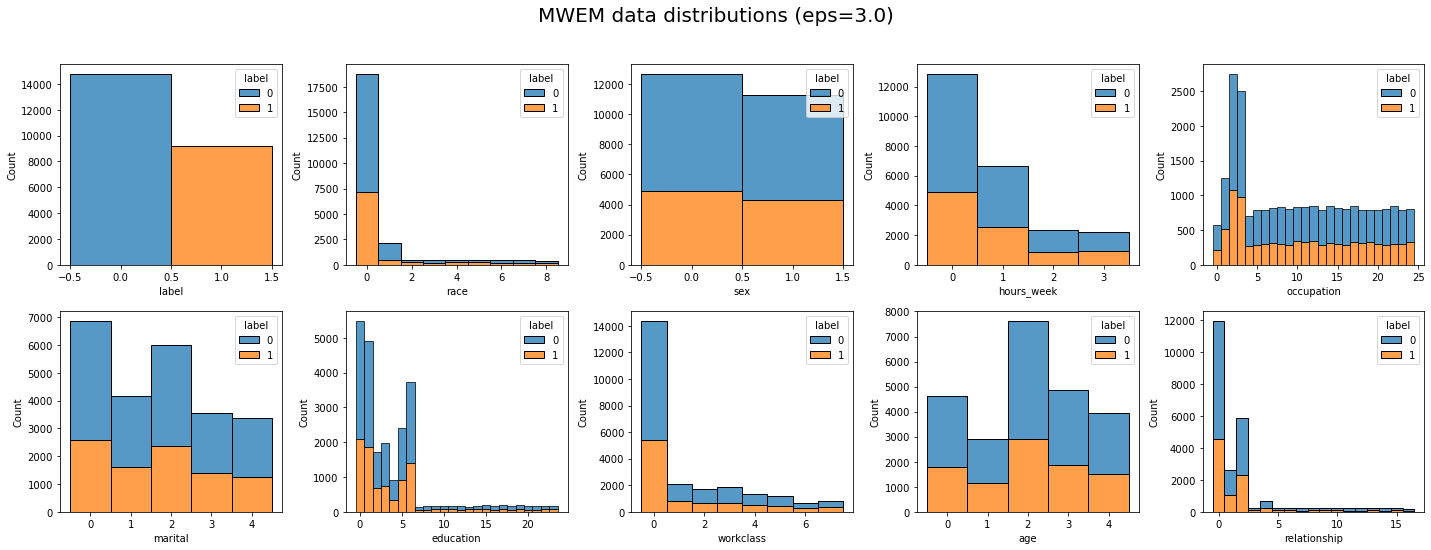

In [10]:
MWEM_eps3_rep0 = pd.read_csv("MWEM_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(MWEM_eps3_rep0, title="MWEM data distributions (eps=3.0)", dataset="acs")

In [11]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.010
FPR difference median: 0.002
F1-score median: 0.108


In [13]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.002
FPR difference median: -0.003
F1-score median: 0.304


# 4. New DP-CTGAN synthesis

In [ ]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", n_reps=10, dataset="acs")


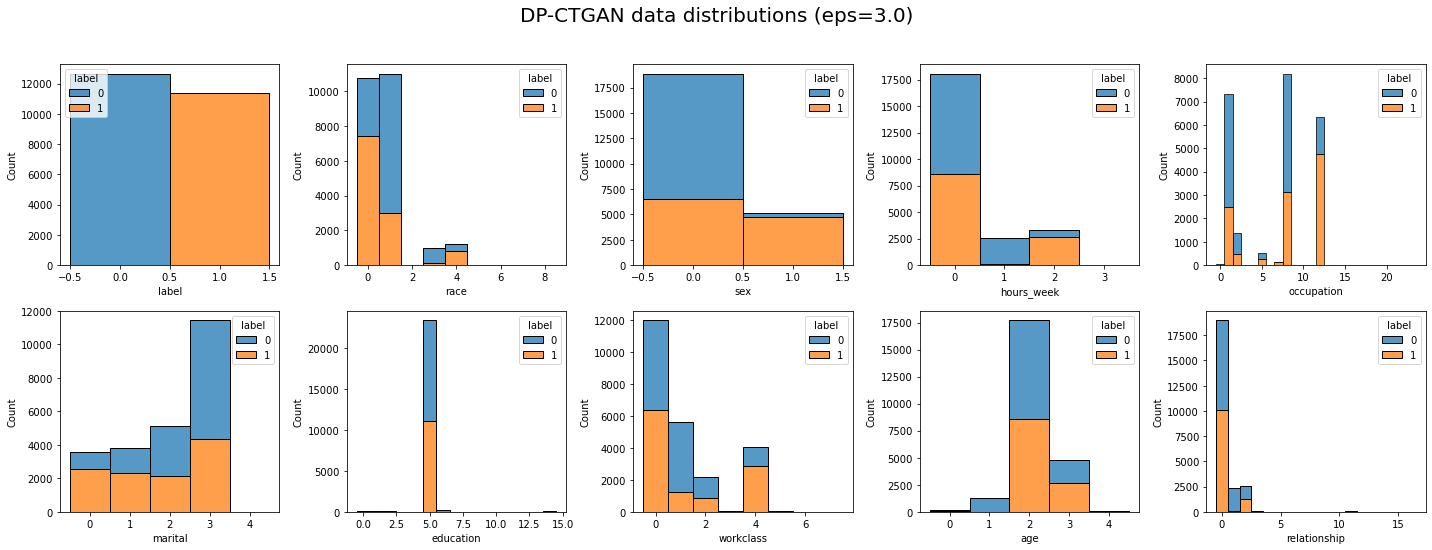

In [15]:
DPCTGAN_eps3_rep0 = pd.read_csv("DPCTGAN_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(DPCTGAN_eps3_rep0, title="DP-CTGAN data distributions (eps=3.0)", dataset="acs")

In [10]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.014
FPR difference median: 0.029
F1-score median: 0.610


In [8]:
# Plot the table metrics for DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.023
FPR difference median: -0.002
F1-score median: 0.584


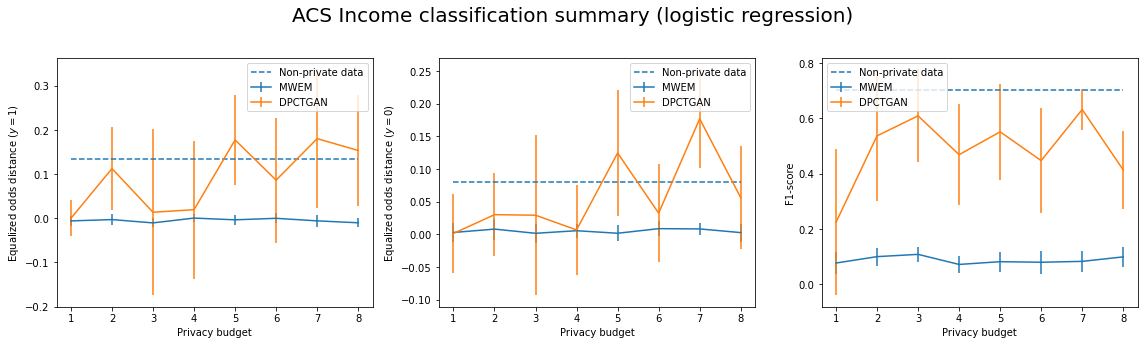

In [11]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")

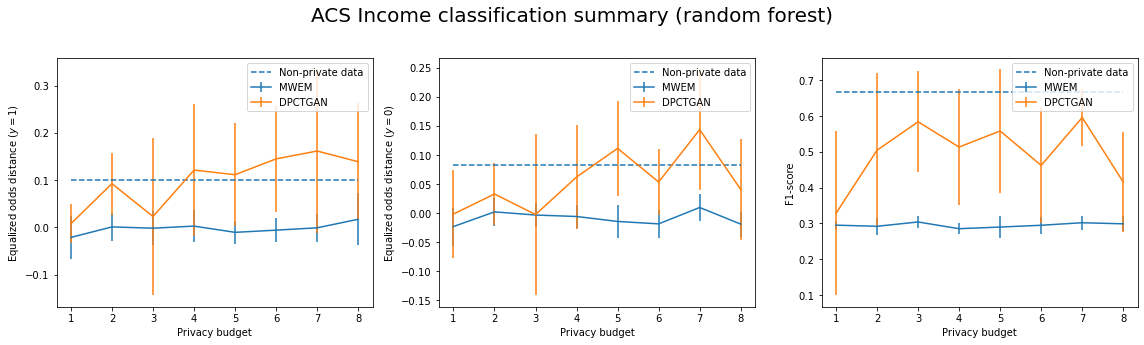

In [12]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")

# 5. New PATE-CTGAN synthesis

In [ ]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

# Generate 10 repetitions of synthetic data with PATE-CTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", n_reps=10, dataset="acs")

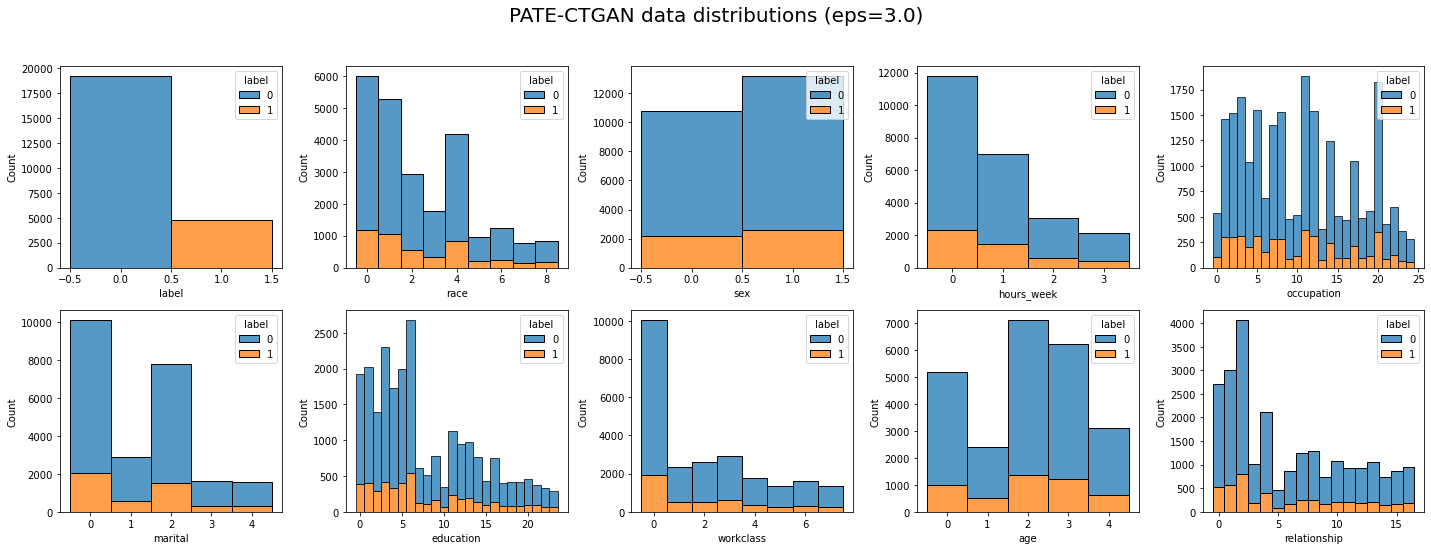

In [21]:
PATECTGAN_eps3_rep0 = pd.read_csv("PATECTGAN_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep0, title="PATE-CTGAN data distributions (eps=3.0)", dataset="acs")

In [22]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.000


In [23]:
# Plot the table metrics for PATECTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.000
FPR difference median: -0.000
F1-score median: 0.010


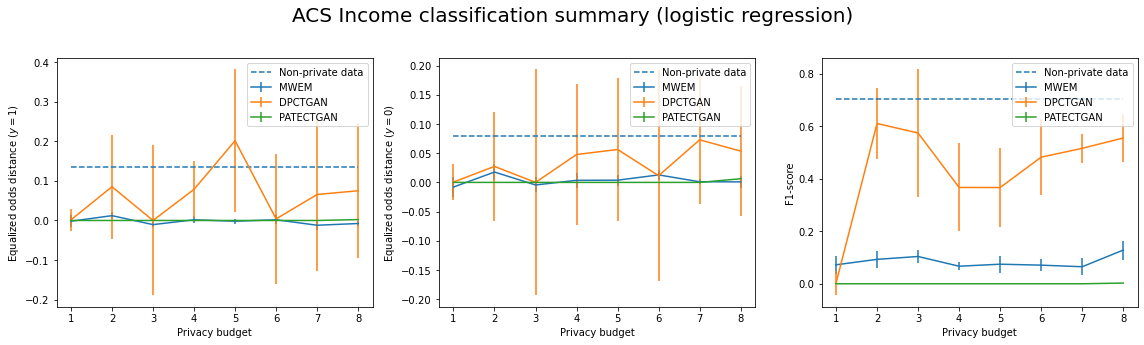

In [24]:
# Plot new MWEM, DP-CTGAN, and PATECTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")

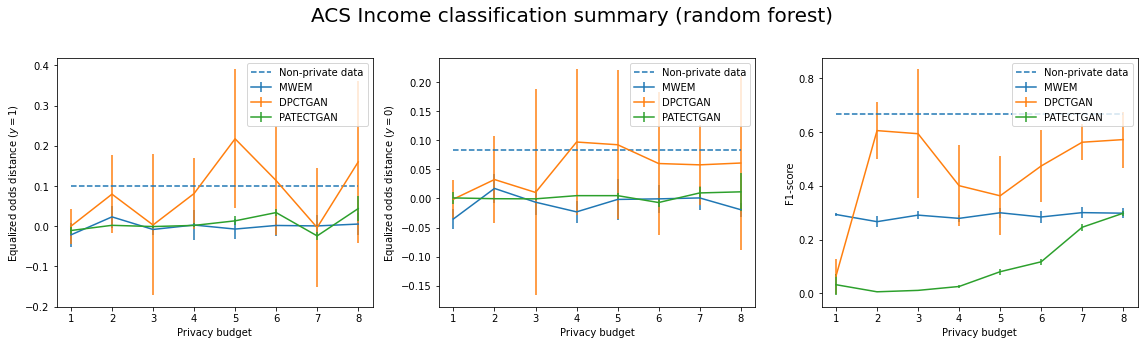

In [25]:
# Plot new MWEM and DP-CTGAN, and PATECTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")

# 6. New QUAIL-MWEM synthesis

In [26]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs")

In [28]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.244
FPR difference median: 0.123
F1-score median: 0.486


In [29]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.218
FPR difference median: 0.112
F1-score median: 0.485


# 7. New QUAIL-DPCTGAN synthesis

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs")

In [31]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.216
FPR difference median: 0.139
F1-score median: 0.437


In [32]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.049
FPR difference median: 0.024
F1-score median: 0.210


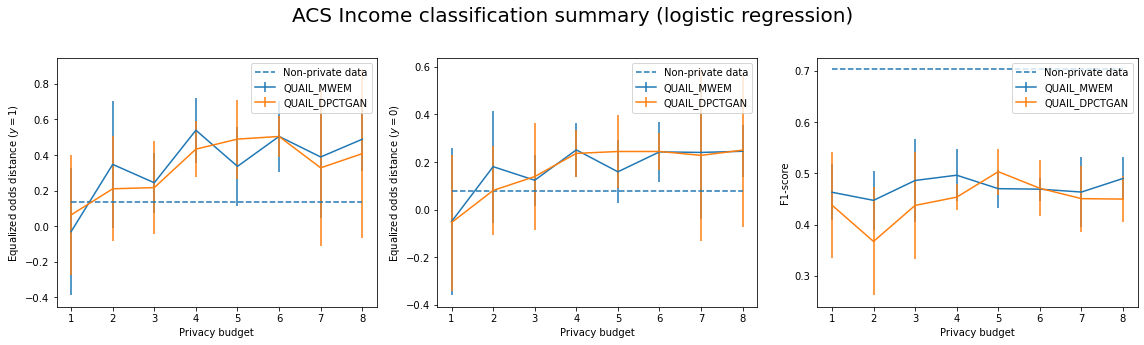

In [33]:
# Plot new MWEM and DPCTGAN results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")


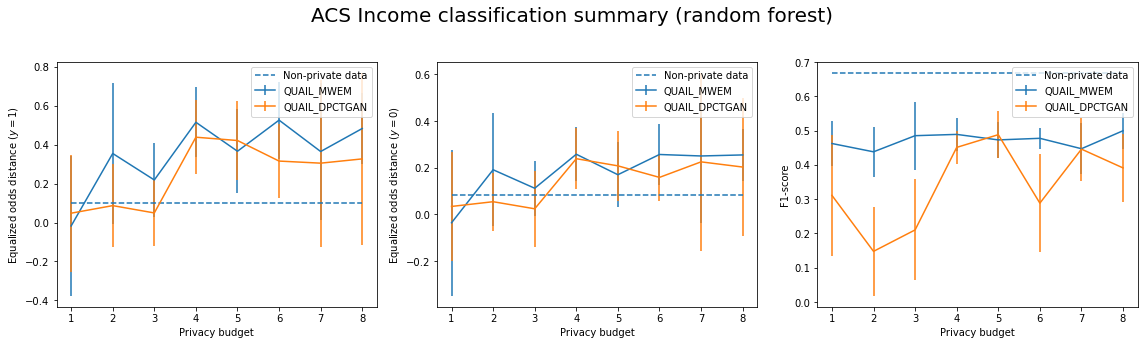

In [34]:
# Plot new MWEM and DPCTGAN results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs")


# 8. New QUAIL-PATECTGAN synthesis

In [8]:
# error: epsilon=1.0 too small?
epsilon_vals = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs")


In [37]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.387
FPR difference median: 0.183
F1-score median: 0.408


In [38]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.020
FPR difference median: 0.013
F1-score median: 0.161


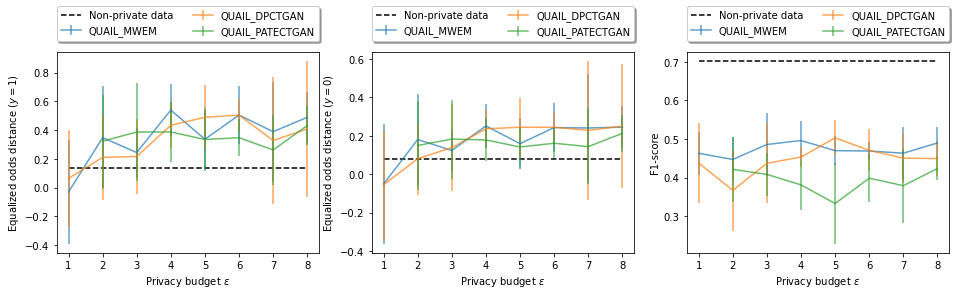

In [8]:
# Save results from all three synthesizers
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs", savefig=True)


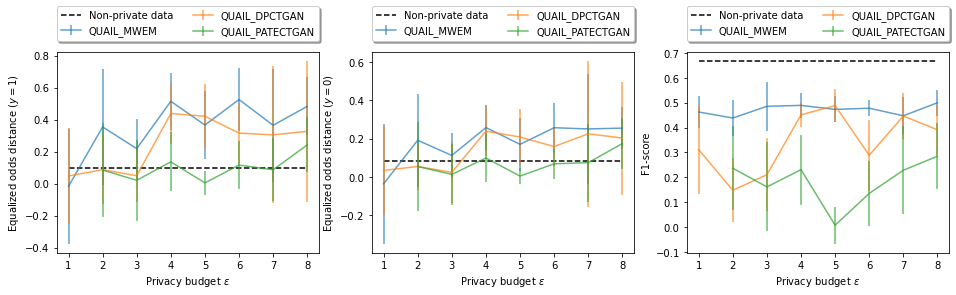

In [9]:
# Save results from all three synthesizers
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs", savefig=True)


# 9. Comparison to DPLR

In [9]:
# Set range of epsilon values
epsilon_vals = [3.0]

# Calculate the median results
tpr_diff_median, fpr_diff_median, f1_score_median = get_dp_model_table_metrics(epsilon_vals, nreps=10, classifier="logistic", train_df=encoded_train, test_df=encoded_test, dataset="acs")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.152
FPR difference median: 0.094
F1-score median: 0.665


# 10. Comparison to k-anonymity

In [10]:
# Convert categorical data into format required by k-anonymization algo
str_cat_train = convert_to_str(cat_train)

In [11]:
# Get the spans of the categorical variables
full_spans = get_spans(str_cat_train, str_cat_train.index)

In [12]:
# Specify the feature columns and label
feature_columns = ["age", "workclass", "education", "occupation",
                   "relationship", "race", "sex", "hours_week", "marital"]
sensitive_column = "label"

# Make partitions for k=5
finished_partitions = partition_dataset(str_cat_train, feature_columns, sensitive_column, full_spans, is_k_anonymous, k=5)

# Get the number of partitions created
len(finished_partitions)

3252

In [13]:
# Build anonymized data set
kanon_df = build_anonymized_dataset(str_cat_train, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...
Finished 1101 partitions...
Finished 1201 partitions...
Finished 1301 partitions...
Finished 1401 partitions...
Finished 1501 partitions...
Finished 1601 partitions...
Finished 1701 partitions...
Finished 1801 partitions...
Finished 1901 partitions...
Finished 2001 partitions...
Finished 2101 partitions...
Finished 2201 partitions...
Finished 2301 partitions...
Finished 2401 partitions...
Finished 2501 partitions...
Finished 2601 partitions...
Finished 2701 partitions...
Finished 2801 partitions...
Finished 2901 partitions...
Finished 3001 partitions...
Finished 3101 partitions...
Finished 3201 partitions...


In [ ]:
# Drop rows with grouped categories
kanon_df = drop_grouped_rows(kanon_df, dataset="acs")
kanon_df

In [16]:
# One-hot encode the k-anonymized data
encoded_kanon = one_hot_encode(kanon_df, dataset="acs")

# Get classification summary for k-anonymized training data
y_train_pred, y_test_pred = get_classification_summary(encoded_kanon, encoded_test, classifier="logistic", dataset="acs")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Female: 0.4418, Male: 0.6768

False positive rates:
Female: 0.1203, Male: 0.2368

Equalized odds distances:
y=1: 0.2351, y=0: 0.1165

Classification accuracies:
Female: 0.7461, Male: 0.7261

F1-score: 0.6204

Avg train pred: 0.3543, Avg test pred: 0.3265


In [17]:
# Get forest classification summary for k-anonymized training data
y_train_pred, y_test_pred = get_classification_summary(encoded_kanon, encoded_test, classifier="forest", dataset="acs")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")



CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Female: 0.3459, Male: 0.4870

False positive rates:
Female: 0.1539, Male: 0.3091

Equalized odds distances:
y=1: 0.1411, y=0: 0.1552

Classification accuracies:
Female: 0.6935, Male: 0.6034

F1-score: 0.4743

Avg train pred: 0.4008, Avg test pred: 0.3027


# 11. Pre-processing (undersampling before synth)

In [21]:
def multi_undersample(cat_df, protected_att, target):
    
    # Count the number of rows for each group and target label
    group0_counts = [len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)])]
    group1_counts = [len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)])]
    all_counts = group0_counts + group1_counts
    
    # Identify the minority count (w.r.t group and label)
    min_count_id = np.argmin(all_counts)
    min_count = all_counts[min_count_id]
    
    # Randomly drop rows from the same group and opposite label
    if min_count_id == 0:
        count_diff = all_counts[1] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 1:
        count_diff = all_counts[0] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 2:
        count_diff = all_counts[3] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)
    else:
        count_diff = all_counts[2] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)    
    
    return cat_df

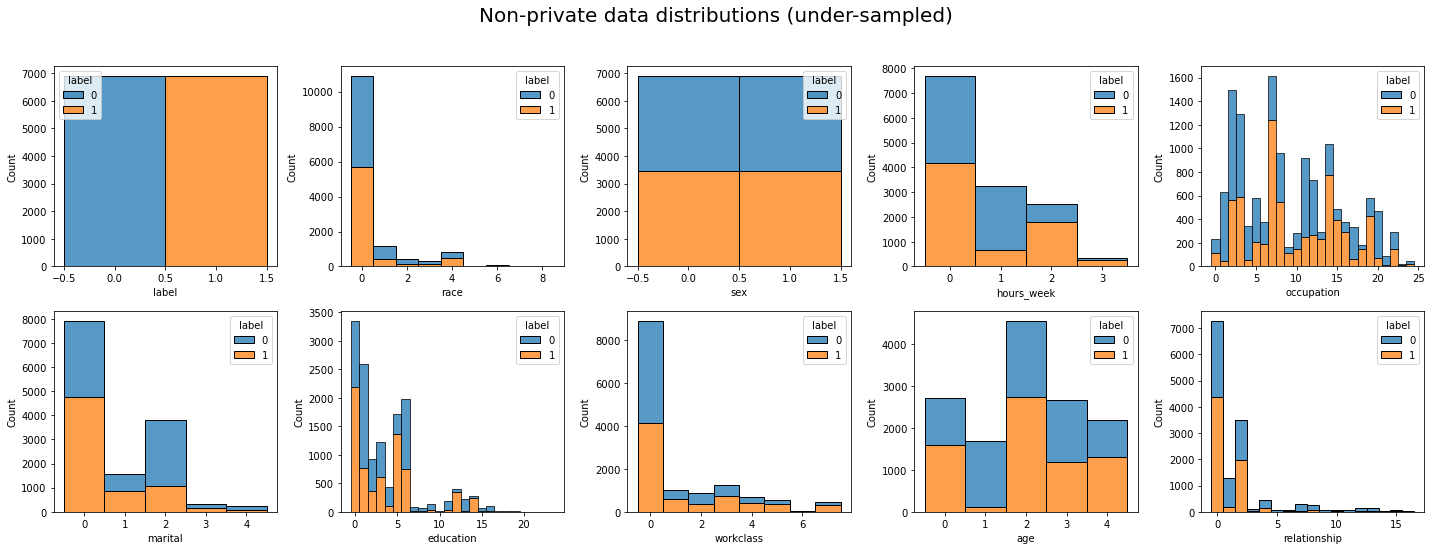

In [22]:
# Balance the groups and labels
multi_balanced = multi_undersample(cat_train, protected_att="sex", target="label")
plot_distributions(multi_balanced, title="Non-private data distributions (under-sampled)", dataset="acs")

In [19]:
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs", results_dir="preprocessed/")


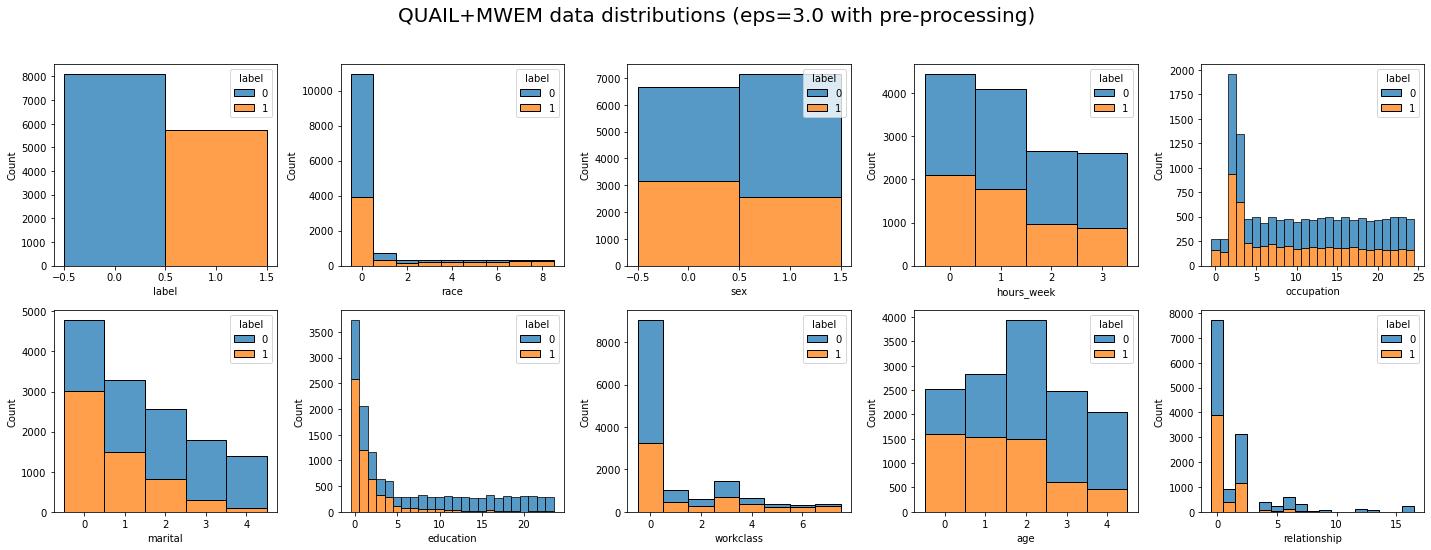

In [21]:
# Plot distributions of pre-processed synthetic data
QUAIL_MWEM_eps3_rep0 = pd.read_csv("preprocessed/QUAIL_MWEM_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(QUAIL_MWEM_eps3_rep0, title="QUAIL+MWEM data distributions (eps=3.0 with pre-processing)", dataset="acs")


In [ ]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs", results_dir="preprocessed/")


In [23]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-PATECTGAN
epsilon_vals = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="PATECTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="acs", results_dir="preprocessed/")


Completed eps=2.0, rep=1.
Completed eps=2.0, rep=2.
Completed eps=2.0, rep=3.
Completed eps=2.0, rep=4.
Completed eps=2.0, rep=5.
Completed eps=2.0, rep=6.
Completed eps=2.0, rep=7.
Completed eps=2.0, rep=8.
Completed eps=2.0, rep=9.
Completed eps=2.0, rep=10.
Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.
Completed eps=4.0, rep=1.
Completed eps=4.0, rep=2.
Completed eps=4.0, rep=3.
Completed eps=4.0, rep=4.
Completed eps=4.0, rep=5.
Completed eps=4.0, rep=6.
Completed eps=4.0, rep=7.
Completed eps=4.0, rep=8.
Completed eps=4.0, rep=9.
Completed eps=4.0, rep=10.
Completed eps=5.0, rep=1.
Completed eps=5.0, rep=2.
Completed eps=5.0, rep=3.
Completed eps=5.0, rep=4.
Completed eps=5.0, rep=5.
Completed eps=5.0, rep=6.
Completed eps=5.0, rep=7.
Completed eps=5.0, rep=8.
Completed

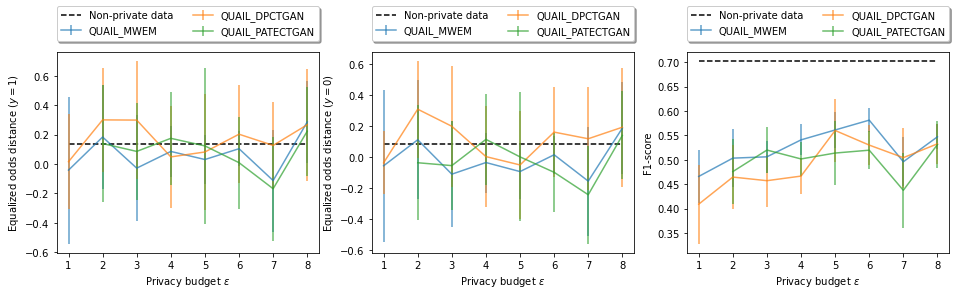

In [24]:
# Save results from all three synthesizers
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/", savefig=True)


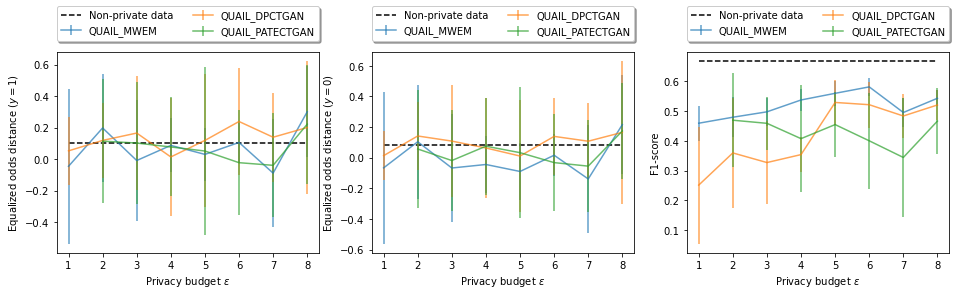

In [25]:
# Save results from all three synthesizers
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/", savefig=True)


In [26]:
# Plot the table metrics for QUAIL-MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.028
FPR difference median: -0.111
F1-score median: 0.506


In [27]:
# Plot the table metrics for QUAIL-DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.299
FPR difference median: 0.197
F1-score median: 0.457


In [28]:
# Plot the table metrics for QUAIL-PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.086
FPR difference median: -0.056
F1-score median: 0.520


#### Legacy: Non-Quail Synth with Preprocessing

In [ ]:
# Generate 10 repetitions of synthetic data with MWEM
#save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="MWEM", n_reps=10, dataset="acs", results_dir="preprocessed/")


In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
#save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="DPCTGAN", n_reps=10, dataset="acs", results_dir="preprocessed/")


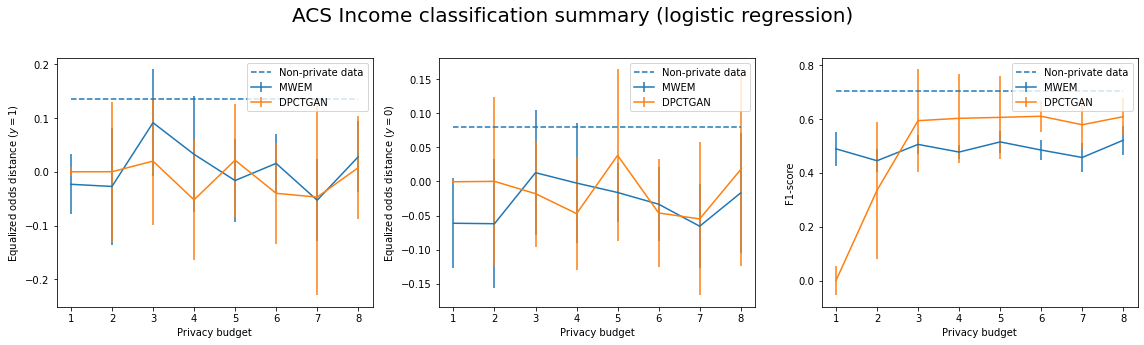

In [29]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/")


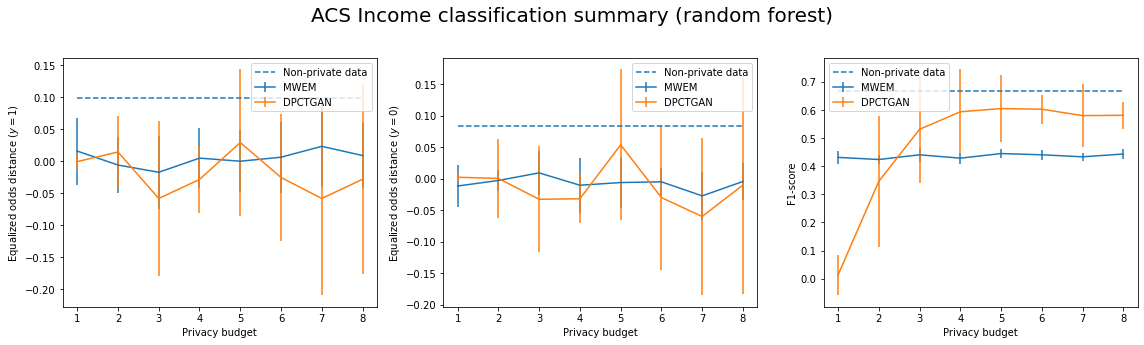

In [30]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="acs", results_dir="preprocessed/")
